# This is the script for combined data performance

In [1]:
import os
import pandas as pd
import numpy as np
import itertools 
import tqdm
import random
import json
import re
import nltk
from time import sleep
import matplotlib.pyplot as plt

# Algorithm package
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF

# Utilities
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
# from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
import warnings 
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
df_raw = pd.read_json("Data/PreparedData.json", lines=True)

In [4]:
df_raw

,Unnamed: 0,IAPTus_Num_x,Referral Date,Age_ReferralRequest_ReceivedDate,EthnicDescGroupCode,EthnicCategoryGroupShortCode,GenderIdentity,SexualOrientationDesc,EndDesc,EndDescGroupShort,...,Item222,Item223,Item224,Item225,patient,round,IAPTus_Num_y,path,text,summarization
0,1,24475,1.536365e+12,5.099020,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,24475,0,NaN,None,None,None
1,2,244761,1.554854e+12,4.358899,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,24476,1,NaN,None,None,None
2,3,244762,1.616890e+12,4.582576,1.0,1.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,0.0,0.0,0.0,0.0,24476,2,NaN,None,None,None
3,4,24479,1.555373e+12,4.898979,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,24479,0,NaN,None,None,None
4,5,24482,1.536278e+12,0.000000,2.0,2.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,NaN,NaN,NaN,NaN,24482,0,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,724,24706,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,24706,0,NaN,None,None,None
724,725,24721,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,24721,0,NaN,None,None,None
725,727,24744,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,24744,0,NaN,None,None,None
726,730,24658,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,24658,0,NaN,None,None,None


# Label Preparing

## Recovery

In [5]:
df = df_raw[df_raw["RecoveryDesc"] == df_raw["RecoveryDesc"]]
df = df[(df["RecoveryDesc"].isin(["At recovery", "Not at recovery"]))]
df.reset_index().drop("index", axis=1)
print(df.shape)

labelList = []
for idx, row in df.iterrows():
    if (row["ReliableChangeDesc"] == "Reliable improvement") & (row["ReliableRecoveryDesc"] == "Reliable recovery") & (row["RecoveryDesc"] == "At recovery"):
        labelList.append(1)
    else:
        labelList.append(0)
df["label"] = labelList
labelList = ["label"]

(391, 285)


# Extra feature Preparation

In [6]:
def tokenize(text, doPreprocessing=True, doLemma=True):
    if doPreprocessing:
        text = " ".join(re.sub(r'[^\w\s]', ' ', text).replace("\n", " ").split())
    # tokens = [x for x in nltk.word_tokenize(text)]
    #print(text)
    tokens = text.split()
    # print(tokens)
    if doLemma:
        # stemmer = SnowballStemmer("english")
        lemma = nltk.wordnet.WordNetLemmatizer()
        tokens = [lemma.lemmatize(item) for item in tokens]
    return tokens

In [7]:
def genLDAFeat(df, param):
    df_corpus = df[df["summarization"] == df["summarization"]][["patient","round","text","summarization"]]
    df_corpus = df_corpus.reset_index().drop("index", axis=1)
    vectorizer_tf = CountVectorizer(
        tokenizer=tokenize,
        max_df=0.95, 
        min_df=2, 
        max_features=param["max_features"], 
        stop_words="english",
        ngram_range=param["ngram_range"],
    )
    tf = vectorizer_tf.fit_transform(df_corpus["summarization"])

    num_topic = param["num_topic"]
    lda = LatentDirichletAllocation(
        n_components=num_topic,
        max_iter=1,
        learning_method="online",
        learning_offset=param["learning_offset"]
    )

    W1 = lda.fit_transform(tf)
    H1 = lda.components_
    # print(vectorizer_tf.get_feature_names_out())

    featCol = ["Topic" + str(i) for i in range(lda.n_components)]
    df_lda = pd.DataFrame(W1, columns=featCol)
    df_lda

    df_final = pd.concat([df_corpus, df_lda], axis=1)
    df_result = pd.merge(df, df_final, on=["patient","round"], how="left")
    return df_result

In [8]:
param_dict = {
    "max_features": 10000,
    "ngram_range": (1,3),
    "num_topic": 15,
    "learning_offset": 100000.0,
}

In [9]:
genLDAFeat(df_raw, param_dict)

,Unnamed: 0,IAPTus_Num_x,Referral Date,Age_ReferralRequest_ReceivedDate,EthnicDescGroupCode,EthnicCategoryGroupShortCode,GenderIdentity,SexualOrientationDesc,EndDesc,EndDescGroupShort,...,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14
0,1,24475,1.536365e+12,5.099020,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,244761,1.554854e+12,4.358899,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,244762,1.616890e+12,4.582576,1.0,1.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,24479,1.555373e+12,4.898979,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,24482,1.536278e+12,0.000000,2.0,2.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,724,24706,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
724,725,24721,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,727,24744,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,730,24658,NaN,0.000000,NaN,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training Utility Function

In [10]:
def SingleModelPlot(resultList, modelName):
    df = pd.DataFrame(resultList)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    values = df.values
    columns = df.columns.tolist()
    axs.violinplot(values,
                  showmeans=False,
                  showmedians=True)
    axs.set_title('Violin plot')

    axs.yaxis.grid(True)
    axs.set_xticks([y + 1 for y in range(len(columns))],
                  labels=columns)
    axs.set_xlabel(modelName)
    axs.set_ylabel('Observed values')

    print("Model: {}\nAccuracy mean: {:.4f}, Precision mean: {:.4f}, Recall Mean: {:.4f}, F1 Mean: {:.4f}".format(
                                                                                                                    modelName,
                                                                                                                    np.mean(df["Accuracy"]), 
                                                                                                                    np.mean(df["Precision"]),
                                                                                                                    np.mean(df["Recall"]),
                                                                                                                    np.mean(df["F1"]),
                                                                                                                )
         )

In [11]:
# mannually generate the search grid
def makeGrid(pars_dict):  
    keys=pars_dict.keys()
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds

In [12]:
def MyGridSearch(model, model_param, param_dict, df_raw, labelList):    
    searchSpace = makeGrid(param_dict)
    print("Search Space Size:" + len(searchSpace).__str__())
    resultList = []
    for param in tqdm.tqdm(searchSpace):
        df = genLDAFeat(df_raw, param)
        # prepare the feature list
        colnames = []
        for item in df.columns:
            if item.startswith("Item") or item.startswith("Tfidf") or item.startswith("Topic"):
                colnames.append(item)
        #sleep(1)
        clf = model(**model_param)
        # scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy", n_jobs=5)
        f1List = []
        skf = StratifiedKFold(n_splits=5)
        for i, (train_index, val_index) in enumerate(skf.split(df[colnames], df[labelList])):
            (X_train, Y_train) = df.iloc[train_index][colnames], df.iloc[train_index][labelList]
            (X_val, Y_val) = df.iloc[val_index][colnames], df.iloc[val_index][labelList]
            clf.fit(X_train, Y_train.values.ravel())
            predicted_val = clf.predict(X_val)
            predicted_val = (predicted_val > 0.5)
            f1 = f1_score(Y_val[labelList], predicted_val)
            f1List.append(f1)
        
        result = {}
        result["f1_mean"] = np.mean(f1List)
        result["f1_std"] = np.std(f1List)
        result["f1"] = f1List
        result["param"] = param
        resultList.append(result)
    sortedResult = sorted(resultList, key=lambda x: x["f1_mean"], reverse=True)
    print(sortedResult[:5])
    return sortedResult

In [13]:
def gen100Prediction(model, model_param, searchResult, df, labelList):
    AccList = []
    for i in range(100):
        param = searchResult[0]["param"]
        df_new = genLDAFeat(df, param)
        colnames = []
        for item in df_new.columns:
            if item.startswith("Item") or item.startswith("Tfidf") or item.startswith("Topic"):
                colnames.append(item)

        # Keep 10% data as the test data
        train, test = train_test_split(df_new, test_size=0.1)
        # train.shape

        clf = model(**model_param)
        clf = clf.fit(train[colnames],train[labelList].values.ravel())

        predicted_test = clf.predict(test[colnames])
        accuracy_score, precision_score, recall_score, f1_score
        result = {}
        result["Accuracy"] = accuracy_score(test[labelList], (predicted_test>0.5))
        result["Precision"] = precision_score(test[labelList], (predicted_test>0.5), average="macro")
        result["Recall"] = recall_score(test[labelList], (predicted_test>0.5), average="macro")
        result["F1"] = f1_score(test[labelList], (predicted_test>0.5), average="macro")  
        AccList.append(result)
    print(AccList)
    return AccList

# TFIDF hyper param search space

In [14]:
param_dict = {
    "max_features": [100, 500, 1000, 5000, 10000, 50000],
    "ngram_range": [(1,1),(1,2),(2,2),(1,3),(2,3),(3,3),(1,4),(2,4),(3,4),(4,4)],
    "num_topic": [5, 10, 15, 20],
    "learning_offset": [1000.0, 5000.0, 10000.0, 50000.0, 100000.0, 500000.0]
}

# DT

In [15]:
model_param = {
    'criterion': 'log_loss', 
    'max_depth': None, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'min_weight_fraction_leaf': 0.0, 
    'max_features': None, 
    'max_leaf_nodes': None
}

In [16]:
searchResult = MyGridSearch(tree.DecisionTreeClassifier, model_param, param_dict, df, labelList)

Search Space Size:1440


100%|██████████| 1440/1440 [05:00<00:00,  4.79it/s]

[{'f1_mean': 0.5717205939672799, 'f1_std': 0.025167205938834904, 'f1': [0.5652173913043478, 0.5567010309278351, 0.5365853658536586, 0.6055045871559633, 0.5945945945945946], 'param': {'max_features': 500, 'ngram_range': (2, 4), 'num_topic': 5, 'learning_offset': 5000.0}}, {'f1_mean': 0.5707103689960833, 'f1_std': 0.05110495713822402, 'f1': [0.58, 0.4935064935064935, 0.5555555555555556, 0.6530612244897959, 0.5714285714285714], 'param': {'max_features': 10000, 'ngram_range': (1, 4), 'num_topic': 10, 'learning_offset': 5000.0}}, {'f1_mean': 0.5706289618535817, 'f1_std': 0.03891612979020865, 'f1': [0.5806451612903226, 0.5783132530120482, 0.574468085106383, 0.6197183098591549, 0.5], 'param': {'max_features': 100, 'ngram_range': (3, 4), 'num_topic': 5, 'learning_offset': 1000.0}}, {'f1_mean': 0.5633152228343322, 'f1_std': 0.06542258168316827, 'f1': [0.5806451612903226, 0.5287356321839081, 0.6419753086419753, 0.6095238095238096, 0.45569620253164556], 'param': {'max_features': 100, 'ngram_range

In [17]:
DTAccList = gen100Prediction(tree.DecisionTreeClassifier, model_param, searchResult, df, labelList)

[{'Accuracy': 0.375, 'Precision': 0.37468671679197996, 'Recall': 0.375, 'F1': 0.37460913070669166}, {'Accuracy': 0.475, 'Precision': 0.4649122807017544, 'Recall': 0.45833333333333337, 'F1': 0.4470046082949308}, {'Accuracy': 0.525, 'Precision': 0.5192307692307692, 'Recall': 0.5175438596491228, 'F1': 0.5099935525467441}, {'Accuracy': 0.5, 'Precision': 0.532967032967033, 'Recall': 0.53125, 'F1': 0.4987468671679198}, {'Accuracy': 0.6, 'Precision': 0.6000000000000001, 'Recall': 0.601010101010101, 'F1': 0.5989974937343359}, {'Accuracy': 0.65, 'Precision': 0.6491228070175439, 'Recall': 0.6491228070175439, 'F1': 0.6491228070175439}, {'Accuracy': 0.625, 'Precision': 0.6142857142857143, 'Recall': 0.5520833333333333, 'F1': 0.5157384987893463}, {'Accuracy': 0.65, 'Precision': 0.641025641025641, 'Recall': 0.6265984654731458, 'F1': 0.6266666666666667}, {'Accuracy': 0.55, 'Precision': 0.55, 'Recall': 0.5505050505050505, 'F1': 0.5488721804511278}, {'Accuracy': 0.55, 'Precision': 0.55, 'Recall': 0.5595

Model: Decision Tree
Accuracy mean: 0.5230, Precision mean: 0.5138, Recall Mean: 0.5130, F1 Mean: 0.4957


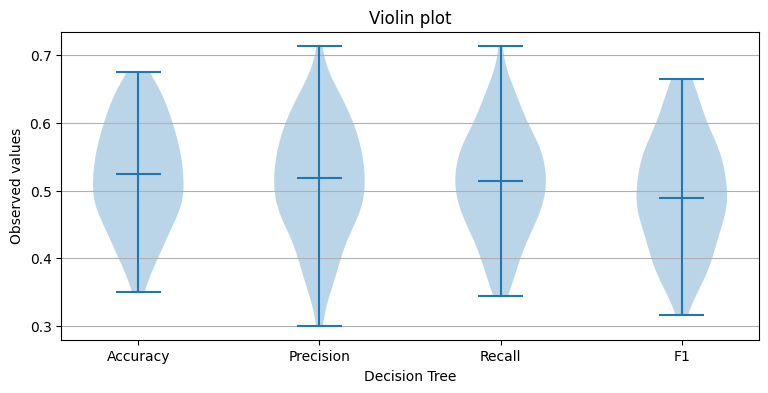

In [18]:
SingleModelPlot(DTAccList, "Decision Tree")

# Random Forest

In [19]:
model_param = {
    'n_estimators': 50, 
    'criterion': 'gini', 
    'max_depth': 16, 
    'max_features': 'sqrt', 
    'max_leaf_nodes': 40, 
    'max_samples': 0.5, 
    'random_state': 9648, 
    'n_jobs': -1
}

In [20]:
searchResult = MyGridSearch(RandomForestClassifier, model_param, param_dict, df, labelList)

Search Space Size:1440


100%|██████████| 1440/1440 [13:19<00:00,  1.80it/s]

[{'f1_mean': 0.38744466174127185, 'f1_std': 0.1929342164883123, 'f1': [0.2222222222222222, 0.28, 0.6875, 0.5423728813559322, 0.20512820512820512], 'param': {'max_features': 50000, 'ngram_range': (2, 2), 'num_topic': 20, 'learning_offset': 500000.0}}, {'f1_mean': 0.3856445860219445, 'f1_std': 0.129638005413249, 'f1': [0.32142857142857145, 0.33962264150943394, 0.35555555555555557, 0.6388888888888888, 0.2727272727272727], 'param': {'max_features': 500, 'ngram_range': (1, 2), 'num_topic': 20, 'learning_offset': 50000.0}}, {'f1_mean': 0.3712913832199546, 'f1_std': 0.11619025416806981, 'f1': [0.20833333333333334, 0.31746031746031744, 0.40816326530612246, 0.5625, 0.36], 'param': {'max_features': 50000, 'ngram_range': (1, 2), 'num_topic': 10, 'learning_offset': 50000.0}}, {'f1_mean': 0.3708460138431913, 'f1_std': 0.12267916866959414, 'f1': [0.2222222222222222, 0.2641509433962264, 0.4745762711864407, 0.5454545454545454, 0.34782608695652173], 'param': {'max_features': 10000, 'ngram_range': (1, 3

In [21]:
RFAccList = gen100Prediction(RandomForestClassifier, model_param, searchResult, df, labelList)

[{'Accuracy': 0.55, 'Precision': 0.4666666666666667, 'Recall': 0.4725274725274725, 'F1': 0.4642857142857143}, {'Accuracy': 0.6, 'Precision': 0.645021645021645, 'Recall': 0.5839598997493735, 'F1': 0.5441595441595442}, {'Accuracy': 0.575, 'Precision': 0.5286738351254481, 'Recall': 0.5208333333333333, 'F1': 0.5054545454545455}, {'Accuracy': 0.55, 'Precision': 0.5714285714285714, 'Recall': 0.531328320802005, 'F1': 0.4642857142857143}, {'Accuracy': 0.625, 'Precision': 0.5694444444444444, 'Recall': 0.5266666666666667, 'F1': 0.48231233822260566}, {'Accuracy': 0.55, 'Precision': 0.6036036036036037, 'Recall': 0.5288220551378446, 'F1': 0.4357366771159875}, {'Accuracy': 0.375, 'Precision': 0.2833333333333333, 'Recall': 0.3337595907928389, 'F1': 0.30118798043326345}, {'Accuracy': 0.625, 'Precision': 0.5694444444444444, 'Recall': 0.5266666666666667, 'F1': 0.48231233822260566}, {'Accuracy': 0.575, 'Precision': 0.5, 'Recall': 0.5, 'F1': 0.4813119755911518}, {'Accuracy': 0.625, 'Precision': 0.61309523

Model: Random Forest
Accuracy mean: 0.5525, Precision mean: 0.5276, Recall Mean: 0.5184, F1 Mean: 0.4834


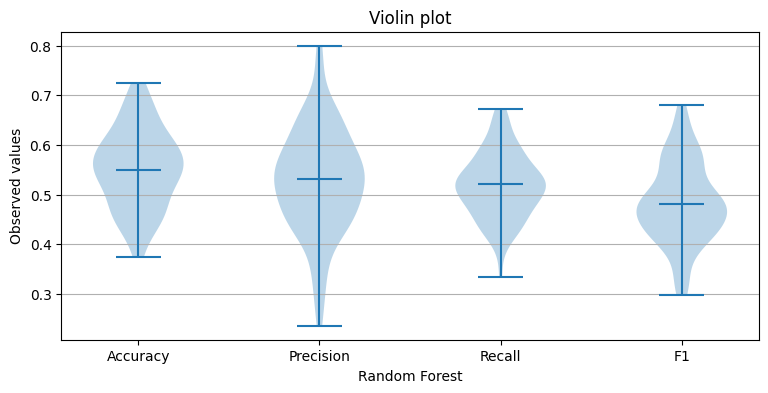

In [22]:
SingleModelPlot(RFAccList, "Random Forest")

# GBM

In [23]:
model_param = {
    'n_estimators': 100, 
    'max_depth': 8, 
    'min_child_samples': 10, 
    'num_leaves': 15, 
    'colsample_bytree': 1.0, 
    'subsample': 0.5, 
    'random_state': 15847, 
    'n_jobs': -1, 
    'verbose': -1
}

In [24]:
searchResult = MyGridSearch(LGBMClassifier, model_param, param_dict, df, labelList)

Search Space Size:1440


100%|██████████| 1440/1440 [31:37<00:00,  1.32s/it]

[{'f1_mean': 0.4527873563218391, 'f1_std': 0.08514817313694166, 'f1': [0.3448275862068966, 0.375, 0.5333333333333333, 0.5625, 0.4482758620689655], 'param': {'max_features': 500, 'ngram_range': (1, 3), 'num_topic': 20, 'learning_offset': 5000.0}}, {'f1_mean': 0.45088846364133406, 'f1_std': 0.057696425373705104, 'f1': [0.3870967741935484, 0.375, 0.4838709677419355, 0.5, 0.5084745762711864], 'param': {'max_features': 1000, 'ngram_range': (3, 4), 'num_topic': 20, 'learning_offset': 1000.0}}, {'f1_mean': 0.44930912679351576, 'f1_std': 0.10282103381793642, 'f1': [0.35714285714285715, 0.3050847457627119, 0.5846153846153846, 0.5084745762711864, 0.49122807017543857], 'param': {'max_features': 10000, 'ngram_range': (4, 4), 'num_topic': 5, 'learning_offset': 1000.0}}, {'f1_mean': 0.44551499717034526, 'f1_std': 0.08456460598407084, 'f1': [0.3508771929824561, 0.375, 0.5, 0.5806451612903226, 0.42105263157894735], 'param': {'max_features': 1000, 'ngram_range': (2, 3), 'num_topic': 15, 'learning_offse

In [25]:
GBMAccList = gen100Prediction(LGBMClassifier, model_param, searchResult, df, labelList)

[{'Accuracy': 0.475, 'Precision': 0.503584229390681, 'Recall': 0.5025252525252525, 'F1': 0.4470046082949308}, {'Accuracy': 0.475, 'Precision': 0.4247311827956989, 'Recall': 0.44696969696969696, 'F1': 0.4129979035639413}, {'Accuracy': 0.525, 'Precision': 0.5085470085470085, 'Recall': 0.5075757575757576, 'F1': 0.49967083607636603}, {'Accuracy': 0.525, 'Precision': 0.5178571428571428, 'Recall': 0.5150375939849624, 'F1': 0.49967083607636603}, {'Accuracy': 0.55, 'Precision': 0.5333333333333333, 'Recall': 0.5319693094629157, 'F1': 0.53125}, {'Accuracy': 0.625, 'Precision': 0.5800000000000001, 'Recall': 0.5892857142857143, 'F1': 0.5807127882599581}, {'Accuracy': 0.475, 'Precision': 0.4004329004329004, 'Recall': 0.44191919191919193, 'F1': 0.3890909090909091}, {'Accuracy': 0.55, 'Precision': 0.5454545454545454, 'Recall': 0.5454545454545454, 'F1': 0.5454545454545454}, {'Accuracy': 0.65, 'Precision': 0.6785714285714286, 'Recall': 0.65, 'F1': 0.6354166666666667}, {'Accuracy': 0.5, 'Precision': 0.4

Model: GBM
Accuracy mean: 0.5420, Precision mean: 0.5177, Recall Mean: 0.5176, F1 Mean: 0.5025


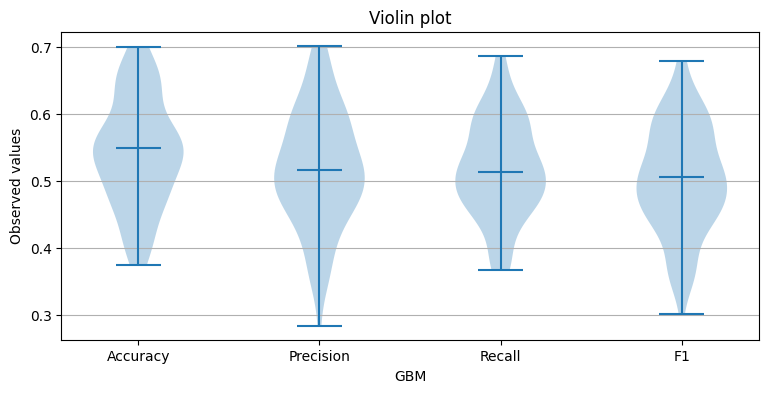

In [26]:
SingleModelPlot(GBMAccList, "GBM")

# XGBoost

In [27]:
model_param = {
    'n_estimators': 150, 
    'max_depth': 16, 
    'objective': 'binary:logistic', 
    'n_jobs': 5, 
    'subsample': 1.0, 
    'colsample_bytree': 1.0, 
    'colsample_bylevel': 0.7, 
    'colsample_bynode': 1.0, 
    'num_parallel_tree': 4
}

In [28]:
searchResult = MyGridSearch(xgb.XGBRegressor, model_param, param_dict, df, labelList)

Search Space Size:1440


100%|██████████| 1440/1440 [45:56<00:00,  1.91s/it]

[{'f1_mean': 0.46165514810019637, 'f1_std': 0.0710054776658464, 'f1': [0.41379310344827586, 0.3548387096774194, 0.5483870967741935, 0.5245901639344263, 0.4666666666666667], 'param': {'max_features': 10000, 'ngram_range': (1, 3), 'num_topic': 5, 'learning_offset': 100000.0}}, {'f1_mean': 0.45470761886816147, 'f1_std': 0.07991949641476603, 'f1': [0.4444444444444444, 0.3333333333333333, 0.5573770491803278, 0.5245901639344263, 0.41379310344827586], 'param': {'max_features': 50000, 'ngram_range': (1, 4), 'num_topic': 20, 'learning_offset': 10000.0}}, {'f1_mean': 0.4514525241479862, 'f1_std': 0.0833837011485106, 'f1': [0.3870967741935484, 0.3389830508474576, 0.5806451612903226, 0.4838709677419355, 0.4666666666666667], 'param': {'max_features': 50000, 'ngram_range': (3, 4), 'num_topic': 20, 'learning_offset': 100000.0}}, {'f1_mean': 0.45103393735843156, 'f1_std': 0.10230693366449811, 'f1': [0.32142857142857145, 0.3389830508474576, 0.5625, 0.5483870967741935, 0.4838709677419355], 'param': {'ma

In [29]:
XGBAccList = gen100Prediction(xgb.XGBRegressor, model_param, searchResult, df, labelList)

[{'Accuracy': 0.75, 'Precision': 0.7711598746081505, 'Recall': 0.7212276214833759, 'F1': 0.7252747252747254}, {'Accuracy': 0.525, 'Precision': 0.5166666666666666, 'Recall': 0.512531328320802, 'F1': 0.4861392832995267}, {'Accuracy': 0.575, 'Precision': 0.45297805642633227, 'Recall': 0.44999999999999996, 'F1': 0.45117029862792574}, {'Accuracy': 0.5, 'Precision': 0.44000000000000006, 'Recall': 0.4294670846394984, 'F1': 0.4301994301994302}, {'Accuracy': 0.575, 'Precision': 0.5166666666666666, 'Recall': 0.5133333333333333, 'F1': 0.5054545454545455}, {'Accuracy': 0.55, 'Precision': 0.5466666666666666, 'Recall': 0.5438596491228069, 'F1': 0.5396419437340154}, {'Accuracy': 0.7, 'Precision': 0.6666666666666667, 'Recall': 0.6538461538461539, 'F1': 0.6581196581196581}, {'Accuracy': 0.575, 'Precision': 0.5576923076923077, 'Recall': 0.5537084398976981, 'F1': 0.5523370638578011}, {'Accuracy': 0.45, 'Precision': 0.43304843304843305, 'Recall': 0.44110275689223055, 'F1': 0.4270833333333333}, {'Accuracy'

Model: XGBoost
Accuracy mean: 0.5643, Precision mean: 0.5407, Recall Mean: 0.5344, F1 Mean: 0.5259


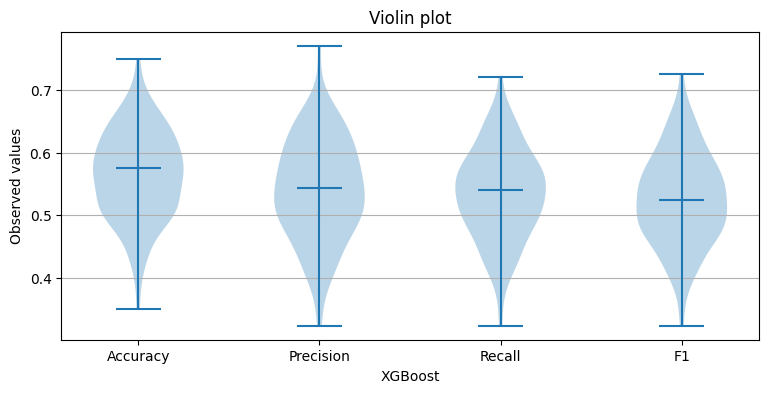

In [30]:
SingleModelPlot(XGBAccList, "XGBoost")

# Comparison

In [31]:
allResult = {}
allResult["Decision Tree"] = DTAccList
allResult["Random Forest"] = RFAccList
allResult["Light GBM"] = GBMAccList
allResult["XGBoost"] = XGBAccList

In [32]:
with open("Combined-LDA-Recovery.json", "w") as writer:
    writer.write(json.dumps(allResult, ensure_ascii=False))

In [33]:
def PreAll(allResult):
    modelList = list(allResult.keys())
    accResult = {}
    preResult = {}
    recResult = {}
    f1Result = {}
    for model in modelList:
        accResult[model] = [x["Accuracy"] for x in allResult[model]]
        preResult[model] = [x["Precision"] for x in allResult[model]]
        recResult[model] = [x["Recall"] for x in allResult[model]]
        f1Result[model] = [x["F1"] for x in allResult[model]]
    return accResult, preResult, recResult, f1Result

def comPlot(Result, Name, ModelList):
    valueList = [Result[model] for model in ModelList]
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    axs.violinplot(valueList,
                  showmeans=False,
                  showmedians=True)
    axs.set_title('Violin plot')
    
    axs.yaxis.grid(True)
    axs.set_xticks([y + 1 for y in range(len(ModelList))],
                  labels=modelList)
    axs.set_xlabel(Name)
    axs.set_ylabel('Observed values')
    
    plt.show()    

In [34]:
accResult, preResult, recResult, f1Result = PreAll(allResult)

In [35]:
modelList = list(accResult.keys())

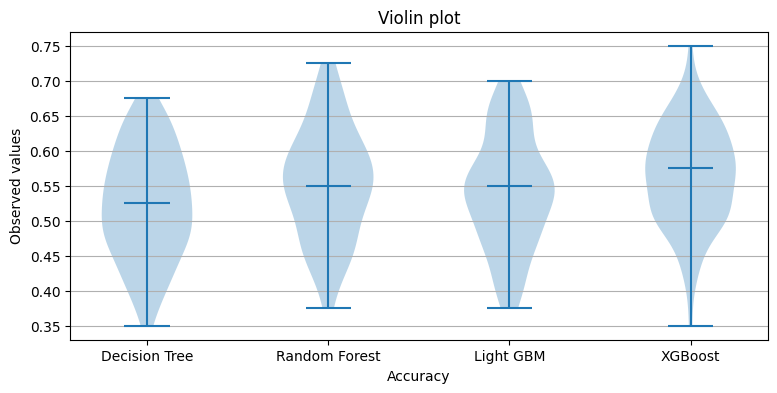

In [36]:
comPlot(accResult, "Accuracy", modelList)

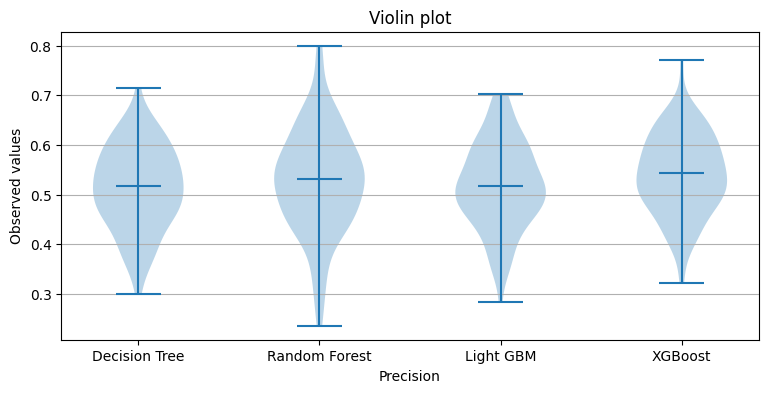

In [37]:
comPlot(preResult, "Precision", modelList)

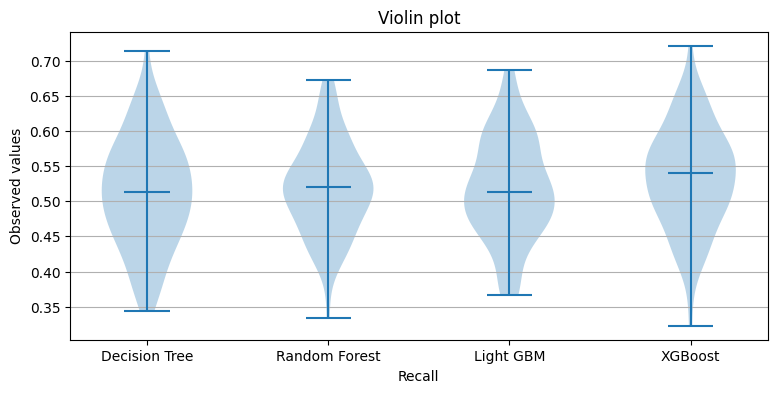

In [38]:
comPlot(recResult, "Recall", modelList)

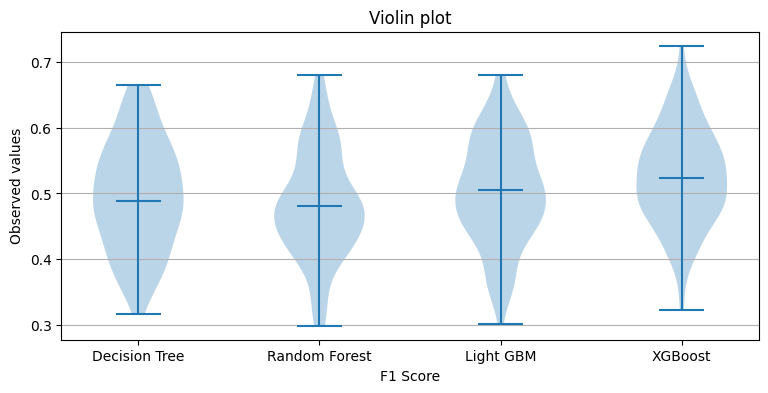

In [39]:
comPlot(f1Result, "F1 Score", modelList)